In [1]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.optimizers import SGD, Adadelta
from keras.layers import Input, Flatten, Dense, Dropout
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import keras
from keras import backend as K


cifar10 = tf.keras.datasets.cifar10
epoch_range = 500

Using TensorFlow backend.


In [2]:
def compressed_weights(model):
    model_weights = np.array(model.get_weights())
    #print(DNN_weights)
    comp = []
    for i in range(len(model_weights)):
        model_weights[i] = model_weights[i].reshape(len(model_weights[i]),-1)
        model_weights[i] = model_weights[i].flatten()
        model_weights[i] = model_weights[i].reshape(len(model_weights[i]),-1)
        #print(model_weights[i].shape)
        for j in range(len(model_weights[i])):
            comp.append(model_weights[i][j])
    comp = np.array(comp).flatten()
    return comp
    

In [3]:
def get_gradients_norm(model, inputs, outputs):
    #from https://stackoverflow.com/questions/51140950/how-to-obtain-the-gradients-in-keras
    """ Gets gradient of model for given inputs and outputs for all weights"""
    grads = model.optimizer.get_gradients(model.total_loss, model.trainable_weights)
    symb_inputs = (model._feed_inputs + model._feed_targets + model._feed_sample_weights)
    f = K.function(symb_inputs, grads)
    x, y, sample_weight = model._standardize_user_data(inputs, outputs)
    output_grad = f(x + y + sample_weight)
    grad_sum = 0
    for i in range(len(output_grad)):
        grad_sum += np.sum(output_grad[i])**2
    grad_norm = grad_sum ** 0.5
    return grad_norm


In [4]:
class MY_DNN1(object):
    def __init__(self, width = 32, height = 32, channels = 3):
        self.width = width
        self.height = height
        self.channels = channels
        
        self.shape = (self.width, self.height, self.channels)
        self.optimizer = SGD(lr=0.01, momentum=0.9, decay=1e-8, nesterov=False)
        
        self.model = self.__model()
        self.model.compile(loss='categorical_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        
    def __model(self):
        inputs = Input(shape = self.shape)
        x = Flatten(input_shape = self.shape)(inputs)
        x = Dense((self.width * self.height * self.channels), activation='relu')(x)
        x = Dense(512)(x)
        y = Dropout(0.2)(x)
        outputs = Dense(10,activation='softmax')(y)
        model = Model(inputs=inputs, outputs=outputs)
        model.summary()
        
        return model
    
    
    def train(self, x_train, y_train, epochs = 500, batch = 256, collect_interval = 3):
        loss = []
        accuracy = []
        weights = []
        grads = []
        
        for cnt in range(epochs):
            history = self.model.fit(x_train, y_train, batch_size=batch, verbose = 0)
            print("epoch:%d ,loss:%s, accuracy:%s "%(cnt, history.history['loss'], history.history['acc']))
            loss.append(history.history['loss'])
            accuracy.append(history.history['acc'])
            grads.append(get_gradients_norm(self.model, x_train, y_train))
            
            if(cnt%collect_interval == 0):
                w = compressed_weights(self.model)
                weights.append(w)
            
        self.loss = loss
        self.accuracy = accuracy
        self.weights = weights
        self.grads = grads

    
                

In [5]:
if __name__ == '__main__':
    if tf.test.gpu_device_name():
        print('GPU found')
    else:
        print("No GPU found")
    
    (x_train, y_train),(x_test, y_test) = cifar10.load_data()
    #normalization for not getting to big output for 'relu' and other activation
    x_train = x_train/255
    x_test = x_test/255
    y_train = np_utils.to_categorical(y_train, num_classes=10)
    y_test = np_utils.to_categorical(y_test, num_classes=10)

    
    #for dense layer, the parameters = (input_shape + 1) * size;
    DNN1 = MY_DNN1()
    DNN1.train(x_train, y_train)
    DNN1.model.save("CIFAR10_DNN1.h5")
    np.save('CIFAR10_DNN1_LOSS', DNN1.loss)
    np.save('CIFAR10_DNN1_ACC', DNN1.accuracy)
    np.save('CIFAR10_DNN1_WEIGHTS',DNN1.weights)
    np.save('CIFAR10_DNN1_GRADS',DNN1.grads)
    
    
    

GPU found
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3072)              9440256   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 11,018,762
Trainable params: 11,018,762
Non-trainable params: 0
______________________________________________________

epoch:108 ,loss:[0.3380013851165771], accuracy:[0.8796599999618531] 
epoch:109 ,loss:[0.31263932472229006], accuracy:[0.888619999961853] 
epoch:110 ,loss:[0.3176896242904663], accuracy:[0.886940000038147] 
epoch:111 ,loss:[0.3181872406578064], accuracy:[0.8858999999809265] 
epoch:112 ,loss:[0.2946019395923615], accuracy:[0.896000000038147] 
epoch:113 ,loss:[0.27926653760910036], accuracy:[0.9033200000381469] 
epoch:114 ,loss:[0.3082379671049118], accuracy:[0.890680000038147] 
epoch:115 ,loss:[0.2747114888763428], accuracy:[0.901459999961853] 
epoch:116 ,loss:[0.28709757471084596], accuracy:[0.89774] 
epoch:117 ,loss:[0.3016858261823654], accuracy:[0.8930000000190735] 
epoch:118 ,loss:[0.3114815327548981], accuracy:[0.8882400000190734] 
epoch:119 ,loss:[0.3079237593841553], accuracy:[0.8914799999809265] 
epoch:120 ,loss:[0.27267543895721436], accuracy:[0.903240000038147] 
epoch:121 ,loss:[0.2619476878738403], accuracy:[0.9073200000190735] 
epoch:122 ,loss:[0.22974244049549103], accuracy

epoch:231 ,loss:[0.06719142640173435], accuracy:[0.9778800000190735] 
epoch:232 ,loss:[0.04003866606473923], accuracy:[0.9871000000190735] 
epoch:233 ,loss:[0.047751926517486575], accuracy:[0.9835000000190735] 
epoch:234 ,loss:[0.04716664914131165], accuracy:[0.9839] 
epoch:235 ,loss:[0.041185259696245195], accuracy:[0.98658] 
epoch:236 ,loss:[0.04379232344150543], accuracy:[0.9858199999809265] 
epoch:237 ,loss:[0.053391228461265566], accuracy:[0.98218] 
epoch:238 ,loss:[0.039812748945355414], accuracy:[0.98732] 
epoch:239 ,loss:[0.047060744523108], accuracy:[0.98534] 
epoch:240 ,loss:[0.05543605313718319], accuracy:[0.9811400000190735] 
epoch:241 ,loss:[0.04124862642526626], accuracy:[0.9861200000190735] 
epoch:242 ,loss:[0.04214758104205132], accuracy:[0.9861600000190734] 
epoch:243 ,loss:[0.05797332073926926], accuracy:[0.9804000000190735] 
epoch:244 ,loss:[0.07876234116554261], accuracy:[0.9729199999618531] 
epoch:245 ,loss:[0.1917799963951111], accuracy:[0.935740000038147] 
epoch:

epoch:359 ,loss:[0.03735532439172268], accuracy:[0.9882800000190735] 
epoch:360 ,loss:[0.024454119576215745], accuracy:[0.992520000038147] 
epoch:361 ,loss:[0.017382330529391764], accuracy:[0.99506] 
epoch:362 ,loss:[0.009825449470989405], accuracy:[0.99786] 
epoch:363 ,loss:[0.006976298555135727], accuracy:[0.99872] 
epoch:364 ,loss:[0.006500240985192358], accuracy:[0.99872] 
epoch:365 ,loss:[0.007671355636427179], accuracy:[0.99816] 
epoch:366 ,loss:[0.008126752878725529], accuracy:[0.9980000000190735] 
epoch:367 ,loss:[0.007406109369397163], accuracy:[0.9985000000190735] 
epoch:368 ,loss:[0.0075450962299853565], accuracy:[0.99808] 
epoch:369 ,loss:[0.007907370497733355], accuracy:[0.99814] 
epoch:370 ,loss:[0.007681457239687443], accuracy:[0.9982] 
epoch:371 ,loss:[0.013589449414908887], accuracy:[0.99596] 
epoch:372 ,loss:[0.00818838562488556], accuracy:[0.99802] 
epoch:373 ,loss:[0.008419446054548025], accuracy:[0.99768] 
epoch:374 ,loss:[0.007499416974782944], accuracy:[0.9985] 


epoch:493 ,loss:[0.0007884477457311004], accuracy:[0.99998] 
epoch:494 ,loss:[0.002256367723764852], accuracy:[0.99974] 
epoch:495 ,loss:[0.0010771511234901846], accuracy:[0.99996] 
epoch:496 ,loss:[0.0008305762485787272], accuracy:[1.0] 
epoch:497 ,loss:[0.0008414628013316542], accuracy:[1.0] 
epoch:498 ,loss:[0.0007778358717262744], accuracy:[1.0] 
epoch:499 ,loss:[0.000762063145916909], accuracy:[1.0] 


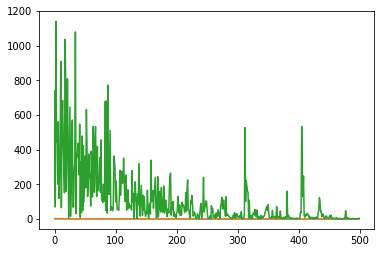

In [6]:
    plt.plot(range(epoch_range), DNN1.loss)
    plt.plot(range(epoch_range), DNN1.accuracy)
    plt.plot(range(epoch_range), DNN1.grads)
    plt.show()
#     pca = PCA(n_components=2)
#     pca.fit(DNN1.weights)
#     x = []
#     y = []
#     for i in range(len(pca.components_)):
#         x.append(pca.components_[i][0])
#         y.append(pca.components_[i][1])
#     plt.scatter(x,y)
